In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


filepath = u"./data/resume_sentence_dataset_balanced2.csv"

data = pd.read_csv(filepath)
data = data.dropna()
data



,Sentence #,Word,Tag
0,0,Govardhana,Name
1,0,K,Name
2,0,Senior,Profil
3,0,Software,Profil
4,0,Engineer,Profil
...,...,...,...
720759,28831,indeed.com/r/Santosh-Ganta/4270d63f03e71ee8,Email Address
720760,28831,Kanagala/04b36892f9d2e2eb,Email Address
720761,28831,Das/152269fb5b986c26,Email Address
720762,28831,indeed.com/r/Shreyanshu-,Email Address


In [3]:
#change date tag to Date instead of 0
#data.loc[data.index[data.Word.str.contains("[0-9]{4}$")],'Tag'] = "Date"

In [4]:
data["Tag"].value_counts()

Skills                 70668
Profil                 65524
Email Address          65524
Degree                 65524
Duration               65524
Date                   65524
College Name           65524
Name                   65524
Location               65524
O                      65416
Companies worked at    60488
Name: Tag, dtype: int64

In [5]:
## remove random O-Tag
#import random
import math

index = data.index[data['Tag'] == "O"]
O_tagSize = math.ceil((len(index)*0.9))

drop_indices = np.random.choice(index, O_tagSize, replace=False)
#data = data.drop(drop_indices)

data["Tag"].value_counts()

Skills                 70668
Profil                 65524
Email Address          65524
Degree                 65524
Duration               65524
Date                   65524
College Name           65524
Name                   65524
Location               65524
O                      65416
Companies worked at    60488
Name: Tag, dtype: int64

In [6]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

14728

In [7]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

11

In [8]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            print(s)
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)

In [9]:
sentences = getter.sentences

In [94]:
#pad word to a length of 50 (why ? Keras need to have same length for each input in the neural net)
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[1]] for w in s] for s in sentences]


X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=0)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post",value=0)

In [12]:
# change label to categorical
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

#X = X.reshape(X.shape[0],X.shape[1],1)
#y = y.reshape(y.shape[0],y.shape[1],1)
#X.shape,y.shape

In [13]:
# split dataset into train (input & label) test (input & label)
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)


In [48]:
import gensim
word_vectors  = gensim.models.Word2Vec.load("saved_model/word2vecEmbedding").wv

MAX_NB_WORDS = len(word_vectors.vocab)
WV_DIM = 50

nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(n_words, WV_DIM) - 0.5) / 5.0
for word, i in word2idx.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass


In [50]:

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,SpatialDropout1D
from keras.layers.normalization import BatchNormalization




embedding_layer = Embedding(n_words,
                     WV_DIM,
                     mask_zero=True,
                     weights=[wv_matrix],
                     input_length=50,
                     trainable=True)


input = Input(shape=(max_len,))
model = embedding_layer(input)
model = SpatialDropout1D(0.2)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)
model.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 50, 50)            736400    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 50, 11)            2211      
Total params: 859,411
Trainable params: 859,411
Non-trainable params: 0
_________________________________________________________________


In [51]:
import tensorflow as tf
import datetime

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [52]:

history = model.fit(X_tr, np.array(y_tr), batch_size=256, epochs=5, validation_split=0.3, verbose=1,shuffle=True)

C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18162 samples, validate on 7785 samples
Epoch 1/5
18162/18162 [==============================] - 44s 2ms/step - loss: 0.4634 - accuracy: 0.7429 - val_loss: 0.1130 - val_accuracy: 0.9648
Epoch 2/5
18162/18162 [==============================] - 44s 2ms/step - loss: 0.0820 - accuracy: 0.9621 - val_loss: 0.0471 - val_accuracy: 0.9771
Epoch 3/5
18162/18162 [==============================] - 47s 3ms/step - loss: 0.0412 - accuracy: 0.9787 - val_loss: 0.0303 - val_accuracy: 0.9816
Epoch 4/5
18162/18162 [==============================] - 45s 2ms/step - loss: 0.0248 - accuracy: 0.9882 - val_loss: 0.0209 - val_accuracy: 0.9887
Epoch 5/5
18162/18162 [==============================] - 46s 3ms/step - loss: 0.0171 - accuracy: 0.9910 - val_loss: 0.0170 - val_accuracy: 0.9901


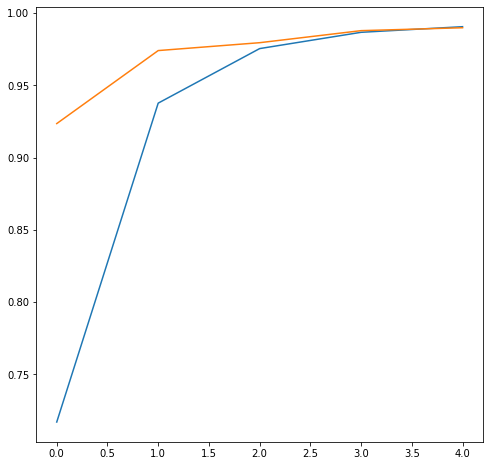

In [37]:
import matplotlib.pyplot as plt
hist = pd.DataFrame(history.history)
plt.figure(figsize = (8, 8))
plt.plot(hist["accuracy"],label="accuracy")
plt.plot(hist["val_accuracy"],label="validation_acc")
plt.show()

In [53]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out


y_pred = model.predict(X_te,verbose=1)

pred_labels = pred2label(y_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
 
print(classification_report(test_labels, pred_labels))

2884/2884 [==============================] - 3s 987us/step
F1-score: 37.4%
                     precision    recall  f1-score   support

             Skills       0.99      0.19      0.32     79741
               Date       0.00      0.00      0.00       274
Companies worked at       0.66      0.63      0.64       698
      Email Address       0.50      1.00      0.66      6668
           Duration       0.00      0.00      0.00       296
       College Name       0.00      0.00      0.00       293
             Profil       0.01      0.01      0.01       292
             Degree       0.01      0.01      0.01       273
               Name       0.00      0.00      0.00       260
           Location       0.00      0.00      0.00       296

          micro avg       0.72      0.25      0.37     89091
          macro avg       0.93      0.25      0.35     89091



In [57]:
i = 655
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
Engineer       : Profil
I              : Profil
Integration    : Profil
Support        : Profil
Engineer       : Profil
partner        : Profil
Trainee        : Profil
cripts         : Profil
Product        : Profil
developer      : Profil
/              : Profil
Center         : Profil
Johnson        : Profil
Engineer       : Profil
Engineer       : Profil
Automation     : Profil
NOC            : Profil
-              : Profil
Dainamic       : Profil
Support        : Profil
Development    : Profil
Committee      : Profil
Engineer       : Profil
Johnson        : Profil
Associate      : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.        : Profil
jQuery.   

In [59]:
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in y_tr]
value = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
print(value)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

[0.93529666 1.0007714  0.9931866  0.99865291 1.07121625 1.01063333
 0.99992293 0.99992293 1.00375242 0.99654338 0.99949923]


In [60]:
history = model.fit(X_tr, np.array(y_tr), batch_size=256, epochs=10, shuffle=True,validation_split=0.1, verbose=1,class_weight=value)

C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23352 samples, validate on 2595 samples
Epoch 1/10
23352/23352 [==============================] - 85s 4ms/step - loss: 0.0138 - accuracy: 0.9918 - val_loss: 0.0098 - val_accuracy: 0.9939
Epoch 2/10
23352/23352 [==============================] - 84s 4ms/step - loss: 0.0106 - accuracy: 0.9935 - val_loss: 0.0083 - val_accuracy: 0.9950
Epoch 3/10
23352/23352 [==============================] - 130s 6ms/step - loss: 0.0085 - accuracy: 0.9947 - val_loss: 0.0069 - val_accuracy: 0.9958
Epoch 4/10
23352/23352 [==============================] - 164s 7ms/step - loss: 0.0071 - accuracy: 0.9955 - val_loss: 0.0065 - val_accuracy: 0.9960
Epoch 5/10
23352/23352 [==============================] - 128s 5ms/step - loss: 0.0062 - accuracy: 0.9960 - val_loss: 0.0062 - val_accuracy: 0.9962
Epoch 6/10
23352/23352 [==============================] - 88s 4ms/step - loss: 0.0055 - accuracy: 0.9964 - val_loss: 0.0061 - val_accuracy: 0.9959
Epoch 7/10
23352/23352 [==============================] - 89s 4ms/

In [63]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out


y_pred = model.predict(X_te,verbose=1)

pred_labels = pred2label(y_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
 
print(classification_report(test_labels, pred_labels))

2884/2884 [==============================] - 4s 1ms/step
F1-score: 37.3%
                     precision    recall  f1-score   support

             Skills       0.99      0.19      0.32     79741
               Date       0.01      0.01      0.01       274
Companies worked at       0.64      0.65      0.65       698
      Email Address       0.50      1.00      0.66      6668
           Duration       0.01      0.01      0.01       296
       College Name       0.04      0.04      0.04       293
             Profil       0.06      0.07      0.06       292
             Degree       0.04      0.04      0.04       273
               Name       0.06      0.06      0.06       260
           Location       0.11      0.10      0.11       296

          micro avg       0.71      0.25      0.37     89091
          macro avg       0.93      0.25      0.34     89091



In [100]:
t1 =["Amadou","NDIAYE","23","years","old","Research","and","Development","Engineer","Training","2016","2019","Diploma","of","Design","Engineer","in","Telecommunications","and","Networks","DIC","Ecole","Supérieure","Polytechnique","de","Dakar","ESP","2014","2016"]
t2 = ["University",
"Diploma",
"of",
"Technology",
"in",
"Telecommunications",
"and",
"Networks",
"DUT",
"Ecole",
"Supérieure",
"Polytechnique",
"de",
"Dakar",
"ESP",
"2013",
"2014",
"Baccalaureate",
"Series",
"S1",
"Sangalcam",
"High",
"School"]
t3 =[
"Languages",
"English",
"Professional",
"French",
"Fluent",
"Wolof",
"Fluent",
"Pular",
"native",
"Technical",
"skills",
"BIG",
"DATA",
"Hadoop",
"2",
"Sqoop",
"2",
"Storm",
"2",
"Avro",
"1",
"5",
"Nifi",
"1",
"5",
"Ambari",
"1",
"5",
"AWS"]
t4 = [
"BIG",     
"DATA",    
"platform",
"for",     
"Atos",    
"Senegal", 
"Mission", 
"s",
"and",     
"Implementation", 
"of",      
"Ambari",  
"in",      
"a",
"6",
"node",    
"cluster", 
"achievements",   
"Installation",   
"of",      
"Hortonworks",    
"Data",    
"Platform",
"and",     
"various", 
"services",
"HDFS",    
"YARN",    
"HIVE",    
"SPARK",   
"SQOOP",   
"on",      
"the",     
"cluster", 
"Cluster", 
"administration", 
"user",    
"management"     
"file",    
"and",     
"service", 
"access",  
"management",     
"Environment",    
"Centos",  
"7",
"Hortonworks"    
]

In [103]:
#test_sentence = ["Data" ,"engineer","-","Microsoft"]

model2 =  keras.models.load_model("./saved_model/lstm_ner_model.h5")
test_sentence =t3
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)

p = model2.predict(np.array([x_test_sent[0]]))

p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))
sequences=[[word2idx.get(w, 0) for w in test_sentence]]


Word           ||Prediction
Languages      : O    
English        : Skills
Professional   : O    
French         : O    
Fluent         : O    
Wolof          : O    
Fluent         : O    
Pular          : O    
native         : O    
Technical      : Skills
skills         : O    
BIG            : O    
DATA           : Skills
Hadoop         : Skills
2              : Skills
Sqoop          : O    
2              : Skills
Storm          : O    
2              : Skills
Avro           : O    
1              : Duration
5              : Duration
Nifi           : O    
1              : Duration
5              : Duration
Ambari         : O    
1              : Duration
5              : Duration
AWS            : Skills


In [91]:
sequences = [t1,t2,t3]
pred_dict = {}
for seq in sequences:
        pred_sentence = pad_sequences(sequences=[[word2idx.get(w, 0) for w in seq]],
                                      padding="post", value=0, maxlen=max_len)
        p = model.predict(np.array([pred_sentence[0]]))
        p = np.argmax(p, axis=-1)
        for w, pred in zip(seq, p[0]):
            pred_dict[w] = tags[pred]
            print("{:15}: {:5}".format(w, tags[pred]))

Amadou         : O    
NDIAYE         : O    
23             : O    
years          : O    
old            : O    
Research       : O    
and            : O    
Development    : O    
Engineer       : O    
Training       : O    
2016           : O    
2019           : O    
Diploma        : Degree
of             : O    
Design         : O    
Engineer       : Profil
in             : O    
Telecommunications: O    
and            : O    
Networks       : O    
DIC            : O    
Ecole          : O    
Supérieure     : O    
Polytechnique  : O    
de             : O    
Dakar          : O    
ESP            : O    
2014           : Date 
2016           : Date 
University     : College Name
Diploma        : Degree
of             : Degree
Technology     : Degree
in             : Degree
Telecommunications: Degree
and            : O    
Networks       : O    
DUT            : O    
Ecole          : O    
Supérieure     : O    
Polytechnique  : O    
de             : O    
Dakar         

In [80]:
##F1 - Score : 89.6%
model.save("saved_model/lstm_ner_model.h5") 